# Check convergence of messages
For each message $\mu$ at iteration $t$, compute $\sum_x \left|\mu^{(t)}(x)-\mu^{(t-1)}(x)\right|$ and check that it goes to zero

## Infinite graph

In [1]:
using MatrixProductBP, MatrixProductBP.Models
using Plots
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using LaTeXStrings;

In [54]:
T = 5         # final time
k = 3          # degree
m⁰ = 0.3       # magnetization at time zero

β = 1.0
J = 0.2
h = 0.0;

In [87]:
import MatrixProductBP.MPEMs: _reshape1
import LinearAlgebra: norm, tr
function trABt(A::MPEM2, B::MPEM2; T = typeof(0.0))
    all(size(a)[3:end] == size(b)[3:end] for (a,b) in zip(A.tensors, B.tensors)) || 
        throw(ArgumentError("Tensor Trains must have same number of states for each variable"))
    toT(A) = convert(T, A)
    Aᵀ =  _reshape1(A[end]) .|> toT
    Bᵀ =  _reshape1(B[end]) .|> toT
    R = sum(Aᵀ[:,:,xᵀ] * Bᵀ[:,:,xᵀ]' for xᵀ in axes(Aᵀ, 3))
    for (At,Bt) in Iterators.drop(Iterators.reverse(Iterators.zip(A,B)), 1)
        Aᵗ = _reshape1(At)
        Bᵗ = _reshape1(Bt)
        R = sum(Aᵗ[:,:,xᵗ] * R * Bᵗ[:,:,xᵗ]' for xᵗ in axes(Aᵗ, 3))
    end
    tr(R)
end

LinearAlgebra.norm(A::MPEM2; T = typeof(0.0)) = sqrt(trABt(A, A; T))

function normAminusB(A::MPEM2, B::MPEM2; T = typeof(0.0)) 
    return sqrt(norm(A; T)^2 + norm(B; T)^2 - 2*trABt(A, B; T))
end

normAminusB (generic function with 1 method)

In [104]:
function CB(bp)
    cb = CB_BP(bp)
    aux = deepcopy(bp.μ)
    matrixdiff = []
    function cb_matrixconvergence(bp, it, svd_trunc)
        Δ = cb(bp, it, svd_trunc)
        diff = [norm(A)^2 + norm(B)^2 - 2*trABt(A, B) for (A, B) in zip(bp.μ, aux)]
        push!(matrixdiff, diff)
        aux = deepcopy(bp.μ)
        Δ
    end
    cb, cb_matrixconvergence, matrixdiff
end

CB (generic function with 1 method)

In [105]:
wᵢ = fill(HomogeneousGlauberFactor(J, h, β), T+1)
ϕᵢ = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T]
bp = mpbp_infinite_graph(k, wᵢ, 2, ϕᵢ);

In [106]:
cb, cb2, matrixdiff = CB(bp)
iters, cb2 = iterate!(bp, maxiter=20; svd_trunc = TruncBond(3), cb=cb2, tol=1e-10, damp=0.5);

Running MPBP: iter 3 	 Time: 0:00:00
  Δ:                0.024710858853560502
  SVD Matrix size:  3

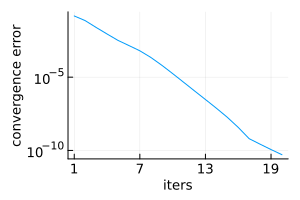

In [90]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

In [91]:
matrixdiff

20-element Vector{Any}:
 [5.35597761171997e-5]
 [6.1742550483743055e-6]
 [7.975957671956403e-7]
 [1.0720151315485402e-7]
 [1.8291245196537693e-8]
 [3.347671774663573e-9]
 [5.331086351447606e-10]
 [6.517651772019323e-11]
 [6.220626336088386e-12]
 [4.977596026328746e-13]
 [3.590487282489896e-14]
 [2.466451522187274e-15]
 [1.6609977282477928e-16]
 [1.0408340855860843e-17]
 [7.589415207398531e-19]
 [2.168404344971009e-19]
 [-1.0842021724855044e-19]
 [-1.0842021724855044e-19]
 [3.2526065174565133e-19]
 [-1.0842021724855044e-19]

## Finite graph

In [110]:
using MatrixProductBP, MatrixProductBP.Models
using Plots, LaTeXStrings 
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using Graphs, IndexedGraphs

In [113]:
T = 5
k = 3
N = 10^2
g = random_regular_graph(N, k)
ising = Ising(IndexedGraph(g); J=fill(J, ne(g)), h=fill(h, N), β)
bp = mpbp(Glauber(ising, T); ϕ = fill(ϕᵢ, N));

In [114]:
cb, cb2, matrixdiff = CB(bp)
iters, cb2 = iterate!(bp, maxiter=20; svd_trunc = TruncBond(3), cb=cb2, tol=1e-10, damp=0.5);

Running MPBP: iter 20 	 Time: 0:00:05
  Δ:                6.269163388195054e-6
  SVD Matrix size:  3

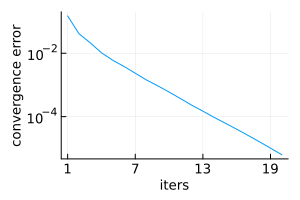

In [115]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

In [117]:
maximum.(matrixdiff)

20-element Vector{Float64}:
 1.7840006101301625e-5
 5.689791019181925e-6
 1.7588246246167793e-6
 6.744165520717943e-7
 2.700079478388075e-7
 1.1061722713756172e-7
 4.558036042492334e-8
 1.895763902879776e-8
 7.913341004499828e-9
 3.307368494093882e-9
 1.3801255016208588e-9
 5.733585654865703e-10
 2.3655027329289036e-10
 9.673134331294325e-11
 3.915293100582168e-11
 1.5672628451111892e-11
 6.201609104722339e-12
 2.425439081348013e-12
 9.376377712450035e-13
 3.583774986840038e-13